<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of image data with augmentation and classification

Das Ziel dieses Beispieles ist es die Organisation, den Import und die Vorbereitung von Bilddaten für eine Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Bilddaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Augmentierung
- Training
- Analyse
- Verbesserung

Der verwendete Datensatz heisst caltech101[3] mit 101 Klassen und jeweils 40 bis 800 Bildern pro Klasse. Die Bilder haben 200 - 300 Pixel Auflösung in Farbe.

Quellen für die Beispiele und Daten:

- [1] [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [2] [https://github.com/bhavul/Caltech-101-Object-Classification](https://github.com/bhavul/Caltech-101-Object-Classification)
- [3] [http://www.vision.caltech.edu/Image_Datasets/Caltech101/](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)



In [1]:
#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)

In [74]:
#
# Import der Module
#
import os
import logging
import tarfile
import operator
import random
from urllib.request import urlretrieve
from PIL import Image, ImageOps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [3]:
!pip install tensorflow

In [42]:
#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on tensorflow {} using sklearn {}'.format ( tf.version.VERSION, sklearn.__version__ ) )

working on tensorflow 2.14.0 using sklearn 1.2.2


# Hilfsfunktionen 

In [6]:
#urlDataSource = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
urlDataSource = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
localExtractionFolder = 'data/caltech-101'
localDataArchive = 'data/caltech-101/101_ObjectCategories.tar.gz'

In [7]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path):
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [8]:
#
# Laden der Daten ausführen
#
#download_dataset(urlDataSource,localDataArchive)
# 

In [9]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/caltech-101/101_ObjectCategories.tar.gz to data/caltech-101 done.


# Organisation von Bilddaten auf dem Filesystem

Eine gute Einführung in das Thema ist zu finden unter

- [Brownlee](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/) 
- [Sarkar](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)

<img src="info.png" align="left"/> 

# Erzeugen der Trainingsdaten

In [10]:
#
# Hilfsfunktionen
#

def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("data directory not found.")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def return_images_per_category(data_directory):
    folder = os.path.join(data_directory,"101_ObjectCategories")
    #print(folder)
    categories=[d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]
    #print(categories)
    return categories



def make_square(im, min_size=256, fill_color=(0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

#
# Lesen der Bilddaten aus einer Datei. Anpassen der Größe auf 70x70 (Breite x Höhe) Pixel.
#
def read_image(image_path):
    im = Image.open(image_path)
    im = make_square(im=im,min_size=70).resize((70,70)).convert("RGB")
    im = ImageOps.autocontrast(im)
    np_img = np.array(im)
    return np_img


#
# Sammelfunktion die alle Kategorien durchgeht und die Files sammelt
#
def create_training_data(data_directory,fraction):
    
    i = 0
    X = []
    Y = []
    
    print("started to read dataset from {}.".format(data_directory) )
    
    for category in return_images_per_category(data_directory):
        
        if category == 'BACKGROUND_Google':
            continue
        
        print(".",end='')
        
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                continue
                
            if random.uniform(0, 1) > fraction:
                continue
                
            X.insert(i, read_image(image) )
            Y.insert(i, category )
            i += 1
    print("")
    print("finished reading dataset.")
    print(X[0].shape)
    X = np.array(X)
    return X,Y

In [11]:
#
# Erzeugen der Trainingsdaten. Der Faktor fraction bestimmt, wieviele Daten wirklich in den Speicher geladen werden.
# Achtung: diese Funktion kümmert sich nicht um die Gleichverteilung der Klassen.
#
X, Y = create_training_data(localExtractionFolder,fraction=0.5)

print('data X={}, y={}'.format(X.shape, len(Y)) )

started to read dataset from data/caltech-101.
.....................................................................................................
finished reading dataset.
(70, 70, 3)
data X=(4355, 70, 70, 3), y=4355


In [12]:
print(Y[:50])

['gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill']


In [13]:
#
# Transformation der Labels in one-hot encoding
#
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_one_hot = to_categorical(Y_integer_encoded)

In [14]:
Y_one_hot.shape

(4355, 101)

In [15]:
#
# Verteilung der Labels
#

<Axes: >

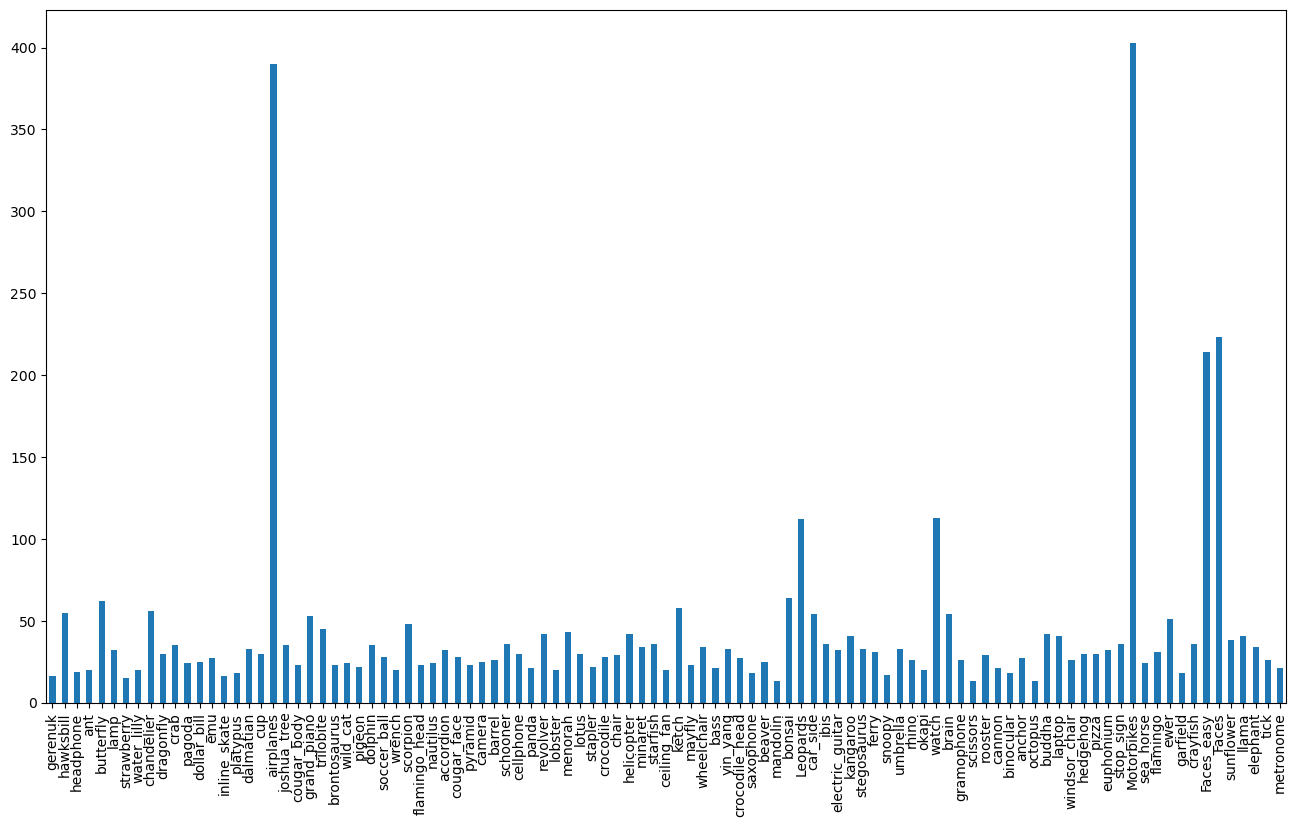

In [16]:
pd.Series(Y).value_counts(sort=False).plot(kind='bar')

In [17]:
#
# Normalisieren der Bilddaten
#
X_normalized = ( X.astype(np.float64) / 255 ) + 0.001

In [18]:
#
# Löschen von X um Speicher gezielt freizumachen
#
del X

In [19]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.20, random_state=42)
del X_normalized


#
# gültige Werte in X_train, X_validation, Y_train, Y_validation, label_encoder, data_directory
#

# Prüfen der Daten

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train: X=(3484, 70, 70, 3), y=(3484, 101)
test: X=(871, 70, 70, 3), y=(871, 101)


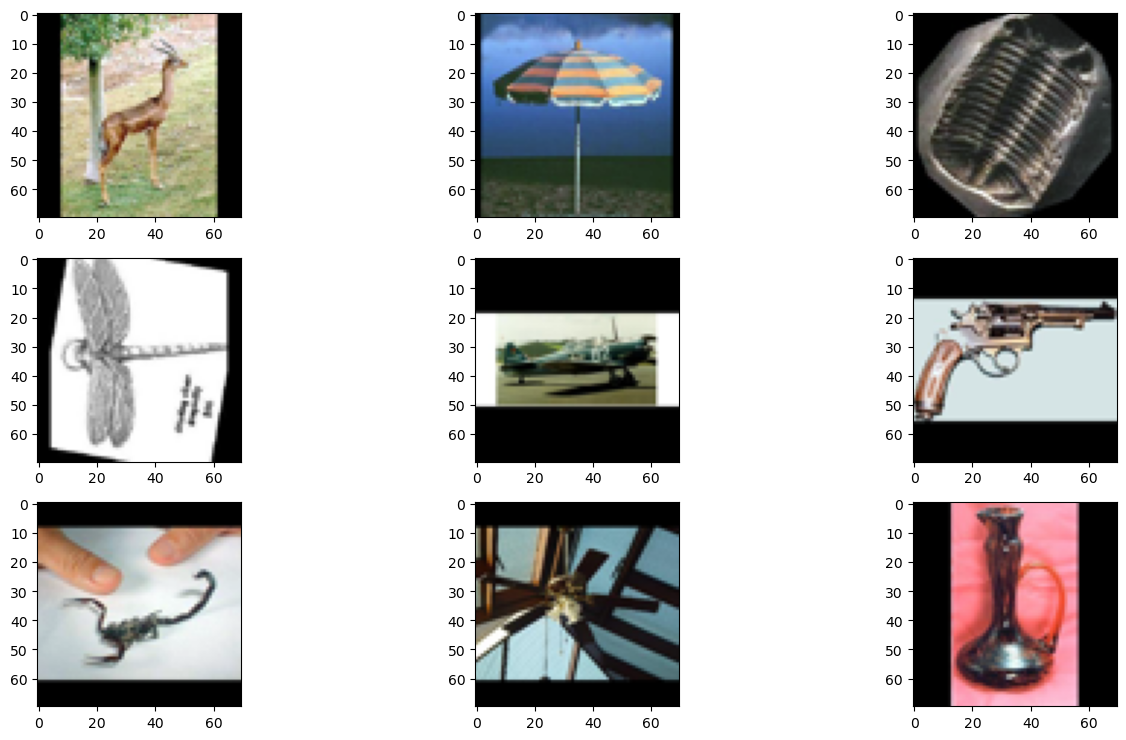

In [20]:
#
# Form der Daten
#
print('train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('test: X=%s, y=%s' % (X_validation.shape, Y_validation.shape))

#
# Plot von Bildern
#
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

# Bauen eines Modelles

In [43]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(70,70,3)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(101, activation='softmax'))
    return model

In [44]:
#
# Compile und Training des Modelles
#
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [45]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 68, 68, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 66, 66, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 66, 66, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 33, 33, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 33, 33, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 31, 31, 128)      

In [46]:
#
# Callbacks steuern das Speichern von Checkpoints und eine Überwachung gegen Overfitting.
#
# 
#
callbacks = [ 
                ModelCheckpoint('model_cnn_weights.h5', monitor='val_accuracy', save_best_only=True),
                EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
]

In [47]:
history = model_cnn.fit(X_train, Y_train, batch_size=16, epochs=6, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/6
218/218 [==============================] - 45s 205ms/step - loss: 40.6719 - accuracy: 0.2557 - val_loss: 20.6457 - val_accuracy: 0.0138
Epoch 2/6
218/218 [==============================] - 47s 217ms/step - loss: 11.6143 - accuracy: 0.4191 - val_loss: 15.5732 - val_accuracy: 0.1309
Epoch 3/6
218/218 [==============================] - 49s 225ms/step - loss: 5.6564 - accuracy: 0.5580 - val_loss: 7.1806 - val_accuracy: 0.4615
Epoch 4/6
218/218 [==============================] - 47s 218ms/step - loss: 2.8947 - accuracy: 0.6817 - val_loss: 9.5411 - val_accuracy: 0.4133
Epoch 5/6
218/218 [==============================] - 56s 256ms/step - loss: 1.9082 - accuracy: 0.7534 - val_loss: 7.0537 - val_accuracy: 0.4891
Epoch 6/6
218/218 [==============================] - 59s 271ms/step - loss: 1.0454 - accuracy: 0.8387 - val_loss: 5.4467 - val_accuracy: 0.5293


In [48]:
#
# Evaluierung des Modelles
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.529 


In [49]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='lightblue', label='test')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.plot(history.history['val_accuracy'], color='lightgreen', label='test')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

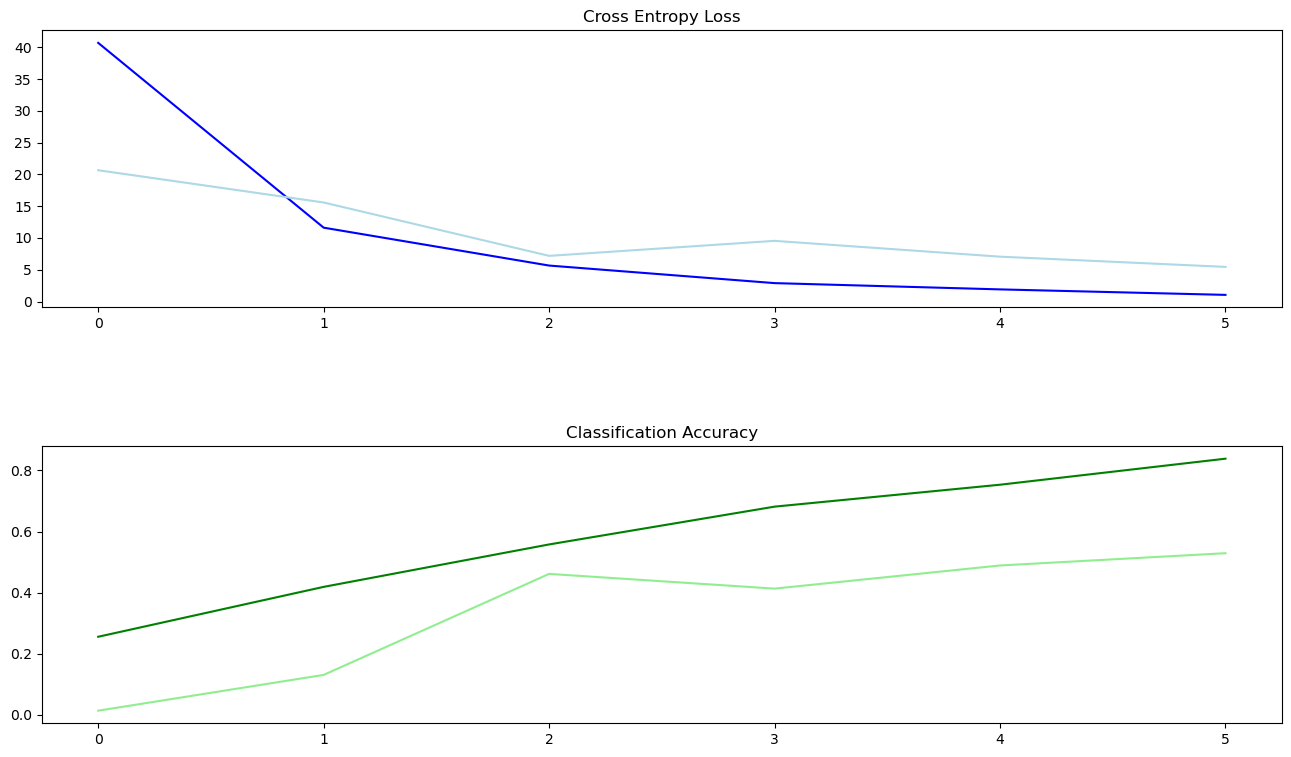

In [50]:
summarize_diagnostics(history,'05_model_cnn')

# Optimiertes Laden der Bilder

Die bisherige Ladefunktion hat alle Bilder in den Speicher geladen. Das führt schnell dazu, dass der Hauptspeicher ausgeht. Daher benötigen wir eine Funktion, die Bilder der Reihe nach in den Speicher lädt und für das Training zur Verfügung stellt.

Eine solche Funktion kann mit einem python **Generator** implementiert werden. Die Erklärung von Generatoren ist hier zu finden [2]. Das Tutorial zum Laden mit Generatoren ist hier [1] zu finden.

Quellen:
- [1] [https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)
- [2] [https://www.python-kurs.eu/generatoren.php](https://www.python-kurs.eu/generatoren.php)


<img src="info.png" align="left"/> 


In [29]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator()

In [30]:
it_train = datagen.flow(X_train, Y_train, batch_size=16)

In [31]:
#
# Training
#
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [32]:
#
# Neue Funktion fit_generator
#
steps = int(X_train.shape[0] / 16)
history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=6, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/6
217/217 [==============================] - 55s 255ms/step - loss: 3.5279 - accuracy: 0.2751 - val_loss: 2.9879 - val_accuracy: 0.3536
Epoch 2/6
217/217 [==============================] - 60s 278ms/step - loss: 2.4509 - accuracy: 0.4495 - val_loss: 2.4335 - val_accuracy: 0.4673
Epoch 3/6
217/217 [==============================] - 58s 267ms/step - loss: 1.7049 - accuracy: 0.5885 - val_loss: 2.2417 - val_accuracy: 0.5029
Epoch 4/6
217/217 [==============================] - 54s 250ms/step - loss: 1.0817 - accuracy: 0.7174 - val_loss: 2.5566 - val_accuracy: 0.4937
Epoch 5/6
217/217 [==============================] - 55s 253ms/step - loss: 0.6708 - accuracy: 0.8126 - val_loss: 2.5133 - val_accuracy: 0.5316
Epoch 6/6
217/217 [==============================] - 55s 255ms/step - loss: 0.3903 - accuracy: 0.8927 - val_loss: 3.1728 - val_accuracy: 0.5270


accuracy 0.527 


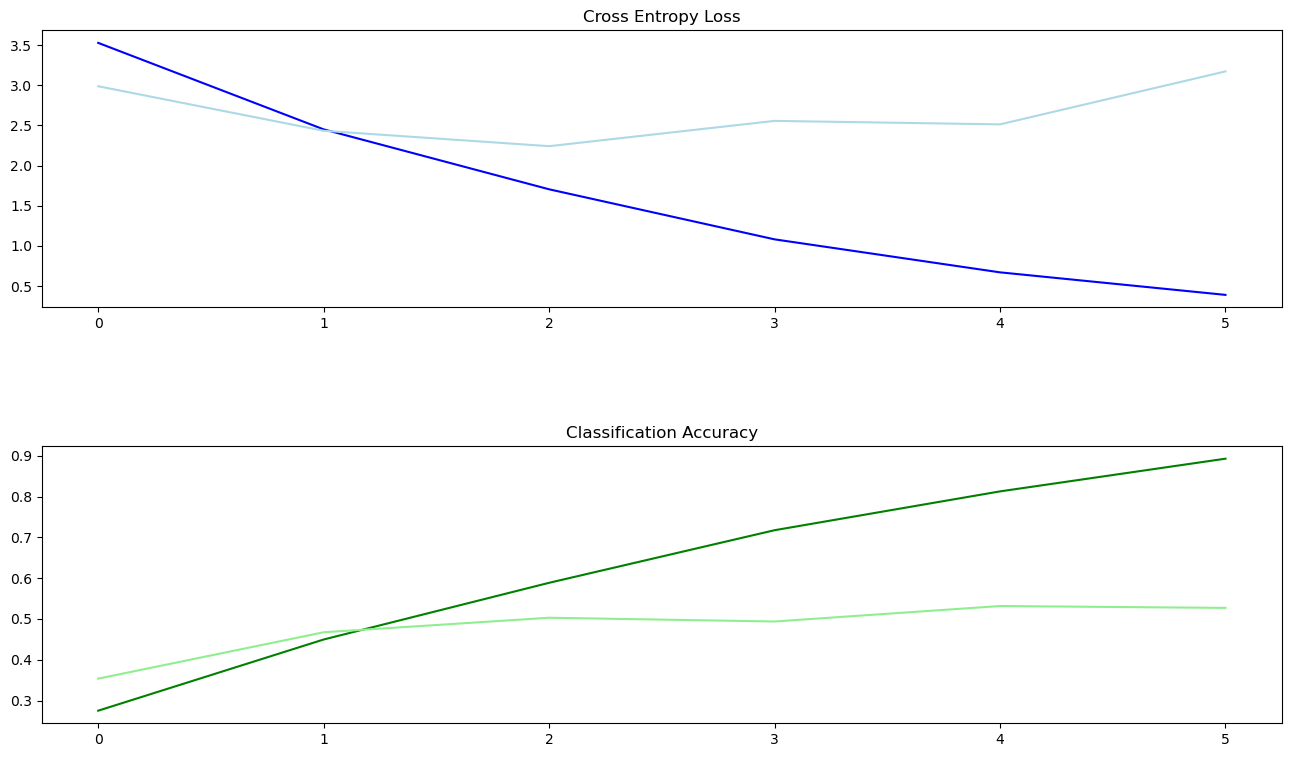

In [33]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )
summarize_diagnostics(history,'model_cnn_gen')

# Optimierung durch Augmentierung

Augmentierung erweitert den Trainingsdatensatz um künstlich erzeugte Bilder. Damit wird erreicht, dass ein Modell robuster wird und sich nicht auf einzelne Pixel bezieht. Methoden der Augmentierung für Bilder sind:

- Breite und Höhe des Bildinhaltes ändern (width_shift_range, height_shift_range)
- Spiegelung (flip)
- Rotation (rotation_range)
- Zoomen (zoom_range)
- Helligkeit (brightness_range)
- Verzerrung (shear_range)

Das Zufügen von Rauschen kann in Keras nicht direkt über den [ImageDataGenerator](https://keras.io/preprocessing/image/) eingestellt werden. Dies wird aber durch die Verwendung von Dropout annähernd simuliert.

<img src="info.png" align="left"/> 


In [56]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=5, zoom_range=0.1 )
# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=16)

In [57]:
#
# Training
#
steps = int(X_train.shape[0] / 16)

In [58]:
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [59]:
history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=24, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/24
217/217 [==============================] - 45s 205ms/step - loss: 59.6888 - accuracy: 0.1750 - val_loss: 40.5581 - val_accuracy: 0.0287
Epoch 2/24
217/217 [==============================] - 53s 243ms/step - loss: 29.4827 - accuracy: 0.2494 - val_loss: 21.3722 - val_accuracy: 0.1584
Epoch 3/24
217/217 [==============================] - 97s 446ms/step - loss: 16.0957 - accuracy: 0.2886 - val_loss: 13.5613 - val_accuracy: 0.1699
Epoch 4/24
217/217 [==============================] - 87s 401ms/step - loss: 9.5627 - accuracy: 0.3279 - val_loss: 6.5720 - val_accuracy: 0.3812
Epoch 5/24
217/217 [==============================] - 81s 371ms/step - loss: 6.1831 - accuracy: 0.3590 - val_loss: 4.6703 - val_accuracy: 0.4489
Epoch 6/24
217/217 [==============================] - 84s 389ms/step - loss: 4.3270 - accuracy: 0.3988 - val_loss: 3.7884 - val_accuracy: 0.4569
Epoch 7/24
217/217 [==============================] - 80s 367ms/step - loss: 3.2189 - accuracy: 0.4501 - val_loss: 3.0465 - 

In [60]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.558 


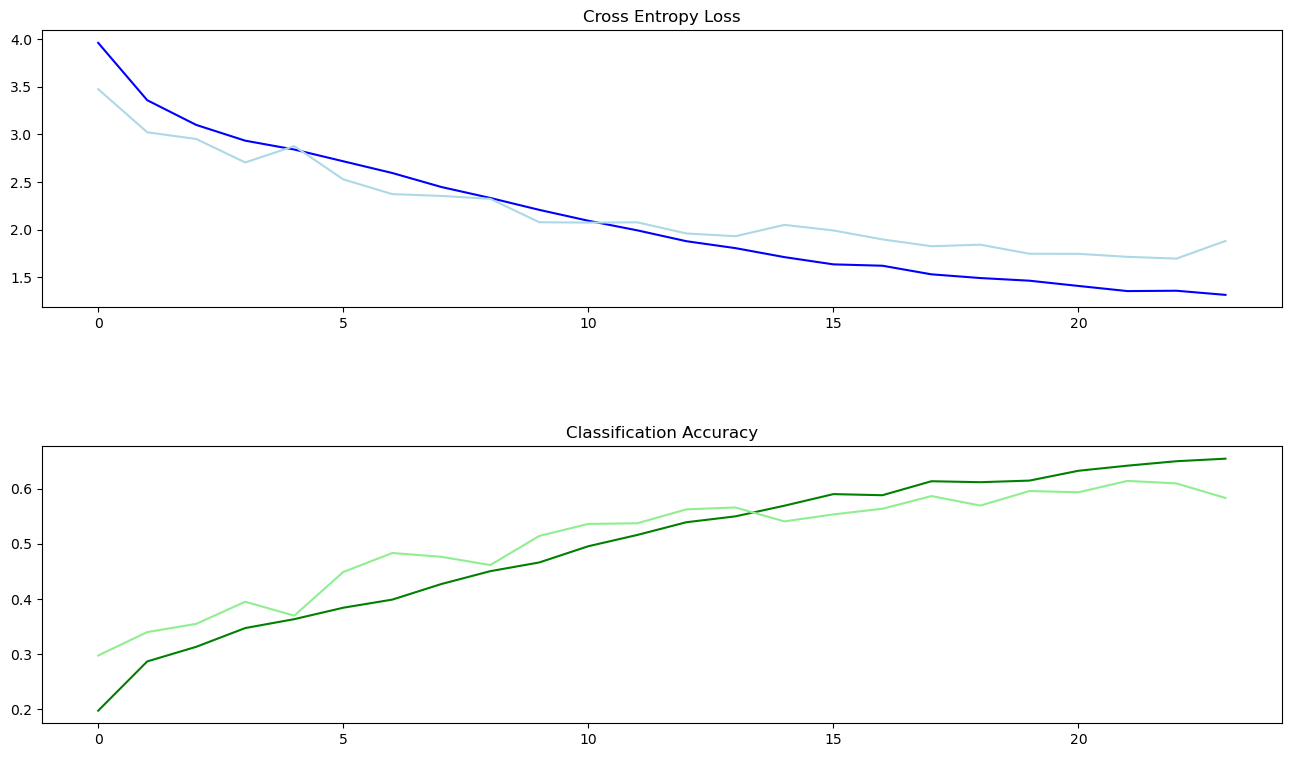

In [39]:
summarize_diagnostics(history,'05_model_cnn_aug')

In [ ]:
#
# Suche nach den Fehlern im Modell
#

In [67]:
Y_pred = model_cnn.predict(X_validation)

In [68]:
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_validation, axis=1)

<Axes: >

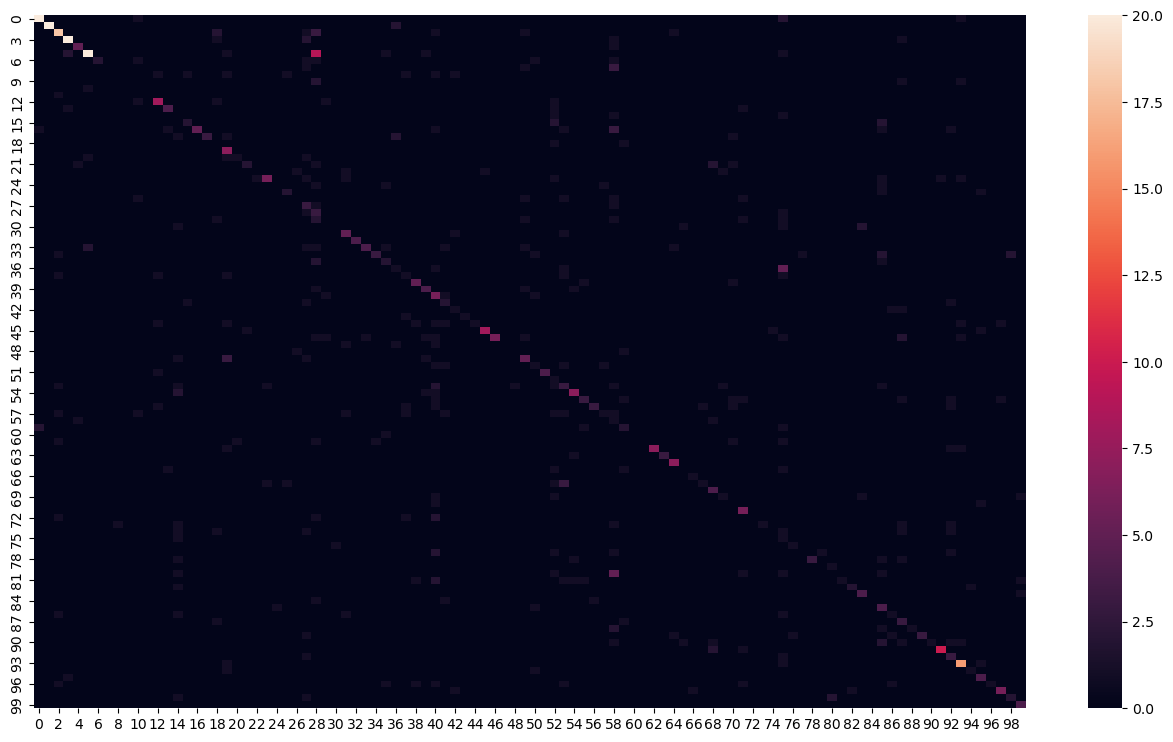

In [79]:
#
# Verteilung der Fehler
#
cf_matrix = np.clip(confusion_matrix(y_true, y_pred), 0, 20)
sns.heatmap(cf_matrix)